# Измерение риска инвестирования

In [1]:
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Располагаемые данные.

In [2]:
df = pd.read_csv('../data/TATN_quotes.csv')

# Оценка реального и нормального распределения доходностей
### Доходность год к году

In [3]:
df['yield'] = df['c'].pct_change() * 100
df.loc[:, ['o', 'c', 'time','yield']] # 'o' - цена открытия, 'c' - цена закрытия

,o,c,time,yield
0,14.730,15.740,2001-12-01T07:00:00Z,NaN
1,24.680,23.690,2002-12-01T07:00:00Z,50.508259
2,30.160,32.850,2003-12-01T07:00:00Z,38.666104
3,42.205,40.979,2004-12-01T07:00:00Z,24.745814
4,98.001,95.223,2005-12-01T07:00:00Z,132.370238
5,129.000,122.020,2006-12-01T07:00:00Z,28.141310
6,145.330,148.490,2007-12-01T07:00:00Z,21.693165
7,45.630,55.260,2008-12-01T07:00:00Z,-62.785373
8,139.900,139.690,2009-12-01T07:00:00Z,152.786826
9,148.500,148.210,2010-11-01T07:00:00Z,6.099220


### Мат. ожидание

In [4]:
mu = df['yield'].mean()

### Дисперсия и Стандартное отклонение

In [5]:
dispersion = df['yield'].var()
sigma = sqrt(dispersion)

### Коэф. асимметрии и коэф. эксцесса

In [6]:
skew = df['yield'].skew()
kurtosis = df['yield'].kurt()

## Сравнение реального и нормального распределения доходностей

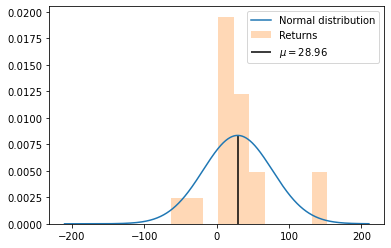

In [7]:
mn = mu - 5 * sigma 
xs = sorted(np.arange(mn, -mn, .05))
ys = [norm.pdf(x, mu, sigma) for x in xs]
h = sorted(np.asarray(df['yield'].dropna()))
plt.plot(xs, ys, label='Normal distribution')
plt.vlines(mu, 0, max(ys), label=f'$\mu = {mu:.2f}$')
plt.hist(h, density=True, histtype='stepfilled', alpha=0.3, label='Returns')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()

## Рассчитаем вероятность получения доходности в заданных пределах

In [8]:
def calc_returns(mu, sigma, i):
    dt = mu - sigma*(i+1)
    dt2 = mu + sigma*(i+1)
    if dt > -100:
        return (
            {'dt':dt}, 
            {'dt2': dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )
    else: 
        return (
            {'dt':-100}, 
            {'dt2':dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )

lst = [calc_returns(mu, sigma, i) for i in range(3)]

In [9]:
ll = [f'\nProbability={i[2]["probability"]:.2%} for values: {i[0]["dt"]:.2f} and {i[1]["dt2"]:.2f}' for i in lst]
print(
    f'\nmu={mu:.2f}', 
    f'\nsigma={sigma:.2f}', 
    f'\nskew={skew:.2f}', 
    f'\nkurtosis={kurtosis:.2f}'
)
print(*ll)
print(f'Bankrupt risk={norm.cdf(-100, mu, sigma):.9%}')


mu=28.96 
sigma=47.86 
skew=1.16 
kurtosis=2.81

Probability=68.27% for values: -18.90 and 76.82 
Probability=95.45% for values: -66.75 and 124.67 
Probability=99.73% for values: -100.00 and 172.53
Bankrupt risk=0.352178536%


## Рассчитаем изменение годовой доходности на различных временных интервалах

In [10]:
def calc_period(year):
    if year == 1:
        return df['yield'].max(), df['yield'].mean(), df['yield'].min() 
    p_df = pd.DataFrame()
    length = len(df)
    n = 0
    for i in range(length):
        while i+year < length:
            start_price = df.loc[i,'c']
            end_price = df.loc[i+year,'c']
            p_df.loc[i+n,'c'] = start_price
            p_df.loc[i+n+1,'c'] = end_price
            # среднегодовая доходность
            p_df.loc[i+n+1,'yield'] = (pow((end_price/start_price), 1/(year+1)) - 1)*100 
            n += year
            break
    return  p_df['yield'].max(), p_df['yield'].mean(), p_df['yield'].min()
    

In [11]:
tbl_constr = {
    'Annual percentage yield': ['Max', 'Mean', 'Min'], 
    '1 year': calc_period(1),
    '3 years': calc_period(3),
    '5 years': calc_period(5),
    '7 years': calc_period(7),
    '10 years': calc_period(10)
}
tbl_df = pd.DataFrame(data=tbl_constr)
tbl_df

,Annual percentage yield,1 year,3 years,5 years,7 years,10 years
0,Max,152.786826,41.593788,40.681735,24.831742,26.169439
1,Mean,28.960151,16.878744,17.122735,16.048992,16.951179
2,Min,-62.785373,-12.719494,4.860516,6.557076,10.753541


## Построим диаграмму годовой доходности на различных временных интервалах

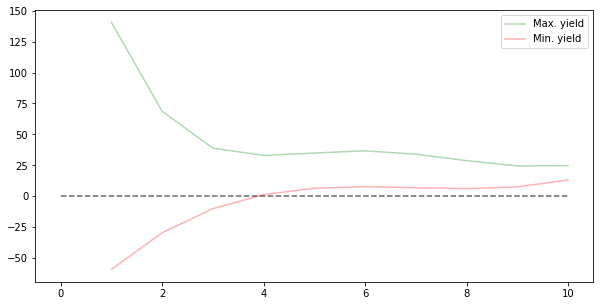

In [12]:
xs = sorted(np.arange(1, 11, 1))
ys_max = [calc_period(x)[0] for x in xs]
ys_min = [calc_period(x)[2] for x in xs]

from scipy.interpolate import splrep, splev

bspl_max = splrep(xs, ys_max, s=1000)
bspl_y_max = splev(xs, bspl_max)

bspl_min = splrep(xs, ys_min, s=1000)
bspl_y_min = splev(xs, bspl_min)

plt.plot(xs, bspl_y_max, label='Max. yield', alpha=0.3, color='green')
plt.plot(xs, bspl_y_min, label='Min. yield', alpha=0.3, color='red')
plt.hlines(0, 0, 10, label=f'', alpha=0.6, linestyle='--')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()